<a href="https://colab.research.google.com/github/juliusberner/oberwolfach_workshop/blob/master/DL_Kolmogorov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [1]:
from ipywidgets import interact
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# using files from github repository also from colab
module_path = Path("modules")
if not (module_path.exists() and module_path.is_dir()):
    repo_path = Path("oberwolfach_workshop")
    if not (repo_path.exists() and repo_path.is_dir()):
        os.system(f"git clone https://github.com/juliusberner/{repo_path.name}.git -q")
    os.chdir(repo_path)

from modules.nn_constructions import affine_combination, identity, square, R, P
from modules.utils import plot_1d


tf.random.set_seed(1234)

### Introduction to Kolmogorov PDEs

In this notebook we present a deep learning based method for solving high-dimensional **Kolmogorov equations (PDEs)**, which are defined by

$$ 
\begin{cases}
\frac{\partial f}{\partial t}(t,x) 
= 
\frac12 \operatorname{Trace}\!\big(
\sigma(x)[\sigma(x)]^{*}\operatorname{Hess}_x f(t,x)\big)
+ 
\big\langle
\mu(x),\nabla_x f(t,x) 
\big\rangle  
\\ 
f(0,x) = \varphi(x). 
\end{cases}
$$

Special cases include, e.g. the heat equation and the Black-Scholes equation from financial engineering (pricing of options).

Our goal will be to compute the evolution of the solution for time $[0,\tau]$ on some hypercube $[u,v]^d$, i.e. the function

$$\color{blue}{f^{sol}:=f(t,x)|_{x\in[u,v]^d, \ t\in[0,T]}} $$

### Simple example

Let
* $\varphi(x):=\|x\|^2_2$
* $\mu(x):=0$
* $\sigma(x):=\sigma \in\mathbb{R}^{d\times d}$

Then it holds that (check!)

$$ f(t,x) = \|x\|_2^2 + t * \operatorname{Trace}(\sigma \sigma^*).$$

In [2]:
d = 1  # space dimension
sigma = 0.05 * tf.ones([d, d]) + 0.5 * tf.eye(d)

In [3]:
def phi(_x):
    return tf.reduce_sum(_x ** 2, axis=1, keepdims=True)


def solution(_t, _x):
    return phi(_x) + _t * tf.linalg.trace(sigma @ tf.transpose(sigma))

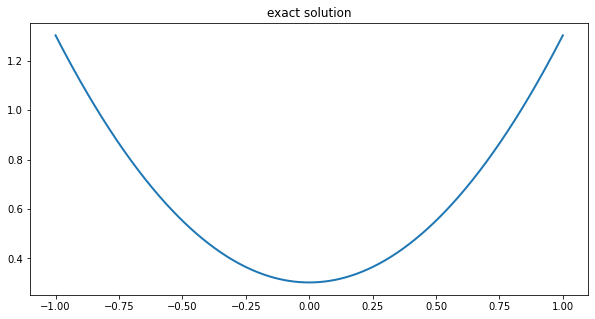

In [4]:
t = 1.0
plot_1d(lambda _x: solution(t, _x), titles=["exact solution"])  # only works for d=1

### Stochastic Interpretation

Our main theoretical tool will be the **Feynman-Kac** formula, stating that (under suitable regularity conditions)

$$\color{blue}{f(t,x)=\mathbb{E}\big[\varphi(S_t^x)\big]},$$

where $S_t^x$ is a solution process to the corresponding stochastic differential equations (**SDE**)

$$S^x_t = x + \int_0^t \mu(S^x_s)\,ds + \int_0^t \sigma(S^x_s)\,dB_s. $$

### ... back to our example

In our example it holds that 

$$S_t^x = x+ \sqrt{t}*  \sigma N,$$

where $N\sim \mathcal{N}(0,I_d)$ is a $d$-dimensional, uncorrelated standard normal random variable.
Accordingly,

$$F(t,x) = \mathbb{E}[\varphi(x+ \sqrt{t}*  \sigma N)].$$

This can, of course, also be seen as convolution between $\varphi$ and the corresponding heat kernel.

### Monte-Carlo Sampling

For specific $x\in\mathbb{R}^d$, $t\in \mathbb{R}$, we can now compute $m$ i.i.d. samples $\mathcal{S}^{x,i}_{t} \sim \mathcal{S}^{x}_{t}$  and approximate the solution to the PDE via **Monte-Carlo sampling**, i.e.

$$ \color{blue}{ f(t,x) = \mathbb{E}\big[\varphi(S_t^x)\big] \approx \frac{1}{m}\sum_{i=1}^m\varphi(\mathcal{S}^{x,i}_{t}) }. $$

In [5]:
x = 0.5 * tf.ones((1, d))  # 0.5*tf.ones([1, d])
t = 1.0  # tf.constant([[1.]])
m = 50

In [6]:
# we compute the realizations efficiently in matrix form
def batched_MC(sigma, phi, _t, _x):

    N = tf.random.normal(shape=tf.shape(_x))
    sigma_N = tf.einsum("ij, kj -> ik", sigma, N)
    # shape = (d, batchsize)
    t_sigma_N = tf.einsum("ij, ki -> ik", tf.sqrt(_t), sigma_N)
    # shape = (batchsize, d)
    return phi(_x + t_sigma_N)


def repeat(tensor, num):
    tensor = tf.reshape(tensor, [1, -1])
    return tf.tile(
        tensor, [num, 1]
    )  # row vectors due to tensorflow convention (we want to reuse this later)


x_rep = repeat(x, m)
t_rep = repeat(t, m)

phi_S = batched_MC(sigma, phi, t_rep, x_rep)
f_approx = tf.reduce_mean(phi_S)

In [7]:
print(
    "exact solution: {:.6f}\nMonte-Carlo Approximation: {:.6f}".format(
        solution(t, x)[0][0], f_approx
    )
)

exact solution: 0.552500
Monte-Carlo Approximation: 0.500079


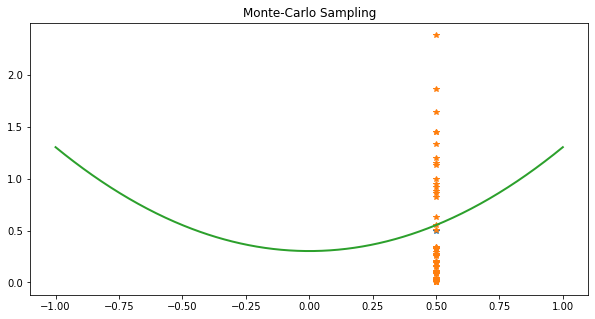

In [8]:
samples = [(x, f_approx), (x_rep, phi_S)]
plot_1d(lambda _x: solution(t, _x), samples=samples, titles=["Monte-Carlo Sampling"])

### Corresponding Learning Problem


This is very nice (especially because it overcomes the curse dimensionality).

But our goal was to numerically compute the solution for **all** $t\in [0,\tau]$ and **all** $x\in[u,v]^d$
(and we want to do machine learning)...

Note that the unique solution to the statistical learning problem 

$$\min_f \mathbb{E} [ (f(X)-Y)^2 ] $$

is given by the **regression** function $E[Y|X=x]$ (assuming $Y$ has finite variance).


1. Let $\color{blue}{(T,X)}\sim \mathcal{U}([0,\tau]\times [u,v]^d)$ be uniformly distributed on the hypercube $[0,\tau]\times [u,v]^d$. 
2. Define $\color{blue}{Y:=\varphi(S^X_T)}$, where $S^X_T$ is the solution to the SDE with initial value $X$ at time $T$.

Then, under sufficient regularity assumptions, the Feynman-Kac formula establishes that

$$f(t,x)=\mathbb{E}\big[\varphi(S_t^x)\big]=\mathbb{E}\big[\varphi(S_T^X)|(T,X)=(t,x)\big]=E[Y|(T,X)=(t,x)] \qquad \forall t\in[0,\tau], \ x\in[u,v]^d.$$

Given $m$ i.i.d. samples $(X^i,Y^i)\sim (X,Y)$ we can thus approximate

$$\color{blue}{f^{sol}=\operatorname{argmin}_f \mathbb{E} [ (f(T,X)-Y)^2 ]\approx \operatorname{argmin}_{f\in \mathcal{N}} \tfrac{1}{m} \sum_{i=1}^m (f(T_i,X_i)-Y_i)^2 },$$

where $\mathcal{N}$ denotes a suitable hypothesis space of neural networks.

In [9]:
u, v = -1.0, 1.0  # approximate solution on the hypercube [u,v]^d
tau = 2.0  # approximate evolution of the solution for [0,tau]
m = int(1e6)  # number of training samples
m_test = 10000  # number of test samples

In [10]:
# training data
X = tf.random.uniform([m, d], minval=u, maxval=v)
T = tf.random.uniform([m, 1], minval=0, maxval=tau)
y_train = batched_MC(sigma, phi, T, X)
x_train = tf.concat([T, X], axis=1)

In [11]:
# model (Keras functional API: https://www.tensorflow.org/guide/keras/functional)
inputs = keras.Input(shape=(d + 1,), name="t_x")
hidden = keras.layers.Dense(100)(inputs)
# hidden = keras.layers.BatchNormalization()(hidden)
hidden = keras.layers.LeakyReLU()(hidden)
hidden = keras.layers.Dense(100)(hidden)
# hidden = keras.layers.BatchNormalization()(hidden)
hidden = keras.layers.LeakyReLU()(hidden)
outputs = keras.layers.Dense(1)(hidden)
learn_model = keras.Model(inputs=inputs, outputs=outputs, name="Kolmogorov_Model")
learn_model.summary()

Model: "Kolmogorov_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
t_x (InputLayer)             [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               300       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
______________________________________________

In [12]:
# test data
X = tf.random.uniform([m_test, d], minval=u, maxval=v)
T = tf.random.uniform([m_test, 1], minval=0, maxval=tau)
y_test = solution(T, X)
x_test = tf.concat([T, X], axis=1)

In [13]:
learn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = learn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1)

31250/31250 [==============================] - 52s 2ms/step - loss: 0.6516 - mae: 0.5189 - val_loss: 0.0016 - val_mae: 0.0341


In [14]:
# visualize the evolution of the (learned) solution
def evaluate(model, _t, _x):
    return model(tf.concat([repeat(_t, _x.shape[0]), _x], axis=1))


interact(
    lambda t: plot_1d(
        [lambda x: evaluate(learn_model, t, x), lambda x: solution(t, x)],
        titles=["model vs. exact solution"],
    ),
    t=(0, tau),
);

interactive(children=(FloatSlider(value=1.0, description='t', max=2.0), Output()), _dom_classes=('widget-inter…

Note that this was just an illustrating example! 

real power of the deep learning approach: it can **overcome the curse of dimensionality**! 

* empirical overservations: 

  Solving a $\color{blue}{100\text{-dimensional}}$ Black-Scholes equation from financial engineering (option pricing) on $[90,110]^{100}$ using dense ReLU networks with architecture $(100,200,200,1)$ [[1]](https://arxiv.org/abs/1806.00421):
  
|Number of descent steps| Relative $\mathcal{L}^1$ error| Relative $\mathcal{L}^\infty$ error | Runtime in seconds|
|-----------------------|-------------------------------|-------------------------------------|-------------------|
| 	0                   |  1.004285                     | 1.009524                            |  1                |
|  100000               |          0.371515             |0.387978                             | 437.9             |
| 250000                |   0.001220                    | 0.010039                            |  1092.6           |
|500000                 |  0.000949                     | 0.005105                            |   2183.8          |

* theoretical explanations: 

  approximation and generalization results for Kolmogorov equations, that do not suffer from the curse of dimensionality [[2]](https://arxiv.org/abs/1809.07669), [[3]](https://arxiv.org/abs/1903.06652), [[4]](https://arxiv.org/abs/1809.03062), ...

In [15]:
# You can now try higher dimensions, different architectures,
# and different Kolmogorov PDEs (see also the SDE solver below)!!
#
#
#
#
#
#
#
#

If you have any questions, please feel free to contact me:  julius.berner@univie.ac.at

## Further Material

### Using our Approximation Framework

We can also explicitely construct a neural network approximating the PDE solution.

Note that this is only the case in our specific simple example, where we know the solution $f(t,x) = \|x\|_2^2 + t * \operatorname{Trace}(\sigma \sigma^*)$.

In [16]:
bound = max([u, v])
trace = tf.linalg.trace(sigma @ tf.transpose(sigma)).numpy()

approx_param = affine_combination(
    [trace, 1.0], pa_list=[identity(), square(1e-10, bound)]
)
approx_model = R(approx_param)

----

In [17]:
# visualizing the learned model, the approximating using the explicit construction, and the exact solution
interact(
    lambda t: plot_1d(
        lambda x: evaluate(learn_model, t, x),
        lambda x: evaluate(approx_model, t, x),
        lambda x: solution(t, x),
        titles=["learned", "approx.", "exact"],
    ),
    t=(0, tau),
);

interactive(children=(FloatSlider(value=1.0, description='t', max=2.0), Output()), _dom_classes=('widget-inter…

In [18]:
# Note that the learned model is significantly smaller.
print(
    "Approx. Model #Parameters: {}\nLearned Model #Parameters: {}".format(
        learn_model.count_params(), approx_model.count_params()
    )
)

Approx. Model #Parameters: 10501
Learned Model #Parameters: 2821


In [19]:
# We could also ftry to urther learn the approx. model
approx_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = learn_model.fit(x_train, y_train, validation_data=(x_test, y_test))

31250/31250 [==============================] - 46s 1ms/step - loss: 0.6494 - mae: 0.5179 - val_loss: 0.0014 - val_mae: 0.0328


In [20]:
# You can try to generalize this to the multidimensional setting by
# by implementing a network approximating the squared euclidean norm!
#
#
#
#
#
#

### Approximation of SDE solution

We now show how to approximately solve the SDE for more complicated coefficient functions.

Let us partition the time interval
$[0,T]$
into
$N$ 
subintervals of equal length, i.e. we set

$$t_n:=\frac{nT}{N}, \quad n\in\{0,1,\dots,N\}.$$ 

Note that for sufficiently small step size 
$\frac{T}{N}=t_{n+1}-t_n$ 
one can approximate 


$$
\color{blue}{ S^x_{t_{n+1}}} = S^x_{t_n} + 
\int_{t_n}^{t_{n+1}} \mu\big(S^x_s\big)\,ds + 
\int_{t_n}^{t_{n+1}} \sigma\big(S^x_s\big)\,dB_s \approx 
\color{blue}{S^x_{t_n} + \mu\big(S^x_{t_n}\big)\,\tfrac{T}{N} + \sigma\big(S^x_{t_n}\big)\underbrace{\big(B_{t_{n+1}}- B_{t_n}\big)}_{\sim \mathcal{N}\big(0,\frac{T}{N}I\big)}}.
$$


This defines the so-called **Euler-Maruyama scheme** $\mathcal{S}^x_n$, which we will implement in the following for affine linear coefficient functions:


**input:**

* initial value $x\in\mathbb{R}^{batchsize \times d}$
* time horizon $T\in(0,\infty)$
* number of Steps $N\in\mathbb{N}$
* value function $\varphi\colon\mathbb{R}^d\to\mathbb{R}$
* affine linear diffusion $\sigma\colon\mathbb{R}^d\to\mathbb{R}^{d \times d}$    
  $\sigma=[\sigma_{ten},\sigma_{mat}]$, $\sigma(x)=[x \sigma_{ten}[0,:,:],\dots,x \sigma_{ten}[d,:,:]]^T + \sigma_{ten}$ (acting on row vectors)
  
* affine linear drift $\mu\colon\mathbb{R}^d\to\mathbb{R}^{d}$      
  $\mu=[\mu_{mat},\mu_{vec}]$, $\mu(x)=x \mu_{mat} + \mu_{vec}$ (acting on row vectors)
  
**output:**

* realizations of $\varphi$ evaluated at end value of the Euler-Maruyama scheme 

$$(\varphi(\mathcal{S}^{x_i}_{N}))_i\in\mathbb{R}^{batchsize}$$


In [21]:
def EM(x, T, N, phi, mu, sigma):

    batch_size, d = tf.shape(x)

    with tf.name_scope("Euler-Scheme"):
        stepsize = tf.divide(T, tf.cast(N, tf.float32), name="Step-Size")
        dw_all = tf.random.normal(
            shape=[N, batch_size, d], mean=0.0, stddev=tf.sqrt(stepsize), name="DW"
        )
        realization = x
        for dw in dw_all[..., :, :]:
            sigma_x = tf.einsum("ij, kjl -> ikl", realization, sigma[0]) + sigma[1]
            # einsum[i,k,l]=\sum_j realization[i,j]*sigma[0][k,j,l]
            # equivalent: einsum[i,k,:]=realization[i,:] @ sigma[0][k,:,:]
            # resulting dim: [batchsize,d,d] + [d,d] (broadcasting applies to addition)
            mu_x = tf.matmul(realization, mu[0]) + mu[1]
            realization += mu_x * stepsize + tf.einsum("ij, ijk -> ik", dw, sigma_x)
            # einsum[i,k]=\sum_j dw[i,j]*sigma_x[i,j,k]
            # equivalent: einsum[i,:]=dw[i,:] @ sigma_x[i,:,:]
            # resulting dim: [batchsize,d] + [batchsize,d]
        return phi(realization)